In [11]:
import numpy as np
import qutip as qt

# Qubit parameters
w_q = 2*np.pi * 1.0    # qubit frequency (GHz, say)
omega = 2*np.pi * 0.05 # drive amplitude (sets π/2 duration)
T1, T2 = 1e3, 1e3      # decoherence times

sx = qt.sigmax()
sz = qt.sigmaz()

sm = np.sqrt(1/T1) * qt.sigmam()

opts = qt.Options(nsteps=1000000)

# Bare Hamiltonian
H0 = 0.5 * w_q * sz

# Build propagator for one H(t) = H0 + Ω cos(ω_d t) σx pulse
def pulse_propagator(w_d, omega, t_pulse):
    H = [
        H0,
        [sx, lambda t, args: 2 * omega * np.cos(w_d * t)]
    ]
    return qt.propagator(H, t_pulse)

# Ramsey expectation value
def ramsey_expectation(tau, w_d1, w_d2, t_pulse):
    U1     = pulse_propagator(w_d1, omega, t_pulse)   # first π/2 at ω_d1
    U_free = qt.propagator(H0, tau, options=opts)     # free evolution
    U2     = pulse_propagator(w_d2, omega, t_pulse)   # second π/2 at ω_d2
    U_tot  = U2 * U_free * U1
    psi0   = qt.basis(2,0)
    psif   = U_tot * psi0
    return qt.expect(sz, psif)

# Example sweep
taus      = np.linspace(0, 200, 201)
detunings = np.linspace(-0.2, +0.2, 5) * 2*np.pi
t_p = np.pi/(2*omega)

data = {}
for delta in detunings:
    w_d1 = w_q + delta
    vals = [ramsey_expectation(tau, w_d1, w_q, t_p) for tau in taus]
    data[delta] = vals

c:\Users\jayamao\.conda\envs\qiskit\lib\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


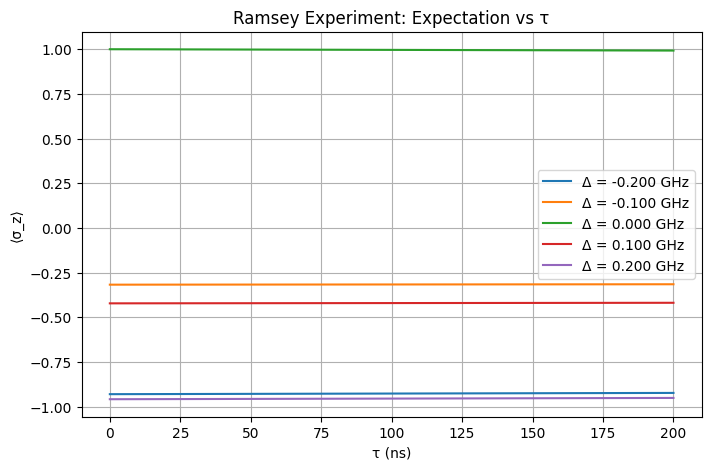

In [12]:
# ...existing code...

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
for delta, vals in data.items():
    plt.plot(taus, vals, label=f"Δ = {delta/(2*np.pi):.3f} GHz")
plt.xlabel("τ (ns)")
plt.ylabel("⟨σ_z⟩")
plt.title("Ramsey Experiment: Expectation vs τ")
plt.legend()
plt.grid(True)
plt.show()
# ...existing code...